# Using the LP mode solver
Pyfiberamp comes with an LP mode solver for simplest possible fiber geometry of cylindrical step-index fibers. Real fibers may have refractive index profiles deviating from the basic step-index shape, which should be kept in mind when interpreting the mode solver results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyfiberamp.mode_solver import LPModeSolver, LPMode, GaussianMode
from pyfiberamp.helper_funcs import beta2_to_d

Initializing the mode solver. The solver precomputes mode cutoffs so the highest l and m parameters must be given at this point. 

In [2]:
mode_solver = LPModeSolver(l_max=100, m_max=50)

# 1. Single-mode fiber

We use the LPModeSolver to solve the fundamental mode of a single-mode fiber. Let's specifically compare numbers to SMF-28: https://www.corning.com/media/worldwide/coc/documents/Fiber/SMF-28%20Ultra.pdf. The core diameter is given in the datasheet. The numerical aperture is chosen by trial and error so that computed mode field diameter matches the reported value. Wavelength is chosen as 1550 nm.

In [3]:
smf28_core_diameter = 8.2e-6
smf28_na = 0.115
smf28_wl = 1550e-9

## 1.1 Solving all modes in a fiber
We set out to solve all the modes in the fiber at 1550 nm and list their main parameters.

LP_0,1 mode of 
fiber with core diameter 8.2 um, NA 0.115 at 1550.00 nm
Effective index: 1.445793
Core overlap: 0.714
Cutoff wavelength: inf nm
Effective area: 85.2 um^2
Effective MFD: 10.42 um


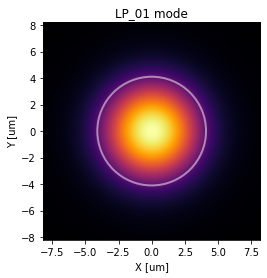

In [4]:
sm_fiber_modes = mode_solver.find_all_modes(core_radius=smf28_core_diameter / 2,
                                            na=smf28_na,
                                            wl=smf28_wl)
assert len(sm_fiber_modes) == 1 # To verify there is only the fundamental mode
sm_mode = sm_fiber_modes[0]

# Let's first print out the mode's main parameters and plot it
print(sm_mode)
sm_mode.plot_intensity()

We found one mode, the fundamental mode, as expected.

## 1.2 Convenience properties of the LPMode class
The LPMode class has the following convenience properties which can be accessed individually. By default the cladding refractive index is assumed to be that of pure bulk fused silica and core index is then computed based on numerical aperture. This may not be accurate for all fibers.

In [5]:
print(f'Propagation constant: {sm_mode.propagation_constant:e} 1/m')
print(f'Effective index: {sm_mode.effective_index:.5f}')
print(f'Effective group index: {sm_mode.group_index:.5f}')
print(f'Core overlap: {sm_mode.core_overlap:.5f}')
print(f'Cutoff wavelength: {sm_mode.cutoff_wl} nm')
print(f'Effective area: {sm_mode.effective_area*1e12:.2f} um^2')
print(f'Effective MFD: {sm_mode.effective_mfd*1e6:.2f} um')

Propagation constant: 5.860763e+06 1/m
Effective index: 1.44579
Effective group index: 1.46734
Core overlap: 0.71449
Cutoff wavelength: inf nm
Effective area: 85.22 um^2
Effective MFD: 10.42 um


Effective mode field diameter (calculated as 2\*sqrt(effective_area / pi) is about the same as in the datasheet due to NA tuning. Effective group index is lower here (1.4673 vs. 1.4682), which I suspect is due to the crude assumption regarding core refractive index, i.e. not taking the germanosilicate doping properly into account.

## 1.3 Dispersion estimation
We can also estimate the fundamental mode's dispersion. The same caveats about concerning the refractive indexes apply. Dispersion is estimated by computing the propagation constant for a number of nearby wavelengths *(n_points_per_side x 2)* at *delta_wl* interval and then fitting a polynomial of order *deg*. The polynomial is then differentiated to obtain the dispersion of various orders. 

In [6]:
beta0, beta1, beta2, beta3 = sm_mode.dispersion(n_points_per_side=20,
                                                         delta_wl=5e-12,
                                                         deg=7)
print(f'Dispersion parameter D = {beta2_to_d(beta2, 1550e-9) * 1e6:.1f} ps/(nm km)')
print(f'Beta2 = {beta2:.2e} s^2/m')
print(f'Beta3 = {beta3:.2e} s^3/m')

Dispersion parameter D = 16.7 ps/(nm km)
Beta2 = -2.13e-26 s^2/m
Beta3 = 5.64e-40 s^3/m


The dispersion parameter lands within the datasheet's specification of D <= 18 ps/(nm km).

## 1.4 Cutoff wavelength
A fiber's cutoff wavelength is the longest wavelength at which the LP_11 mode is guided by the core.
To find it, we need to set a shorter wavelength, find the LP_11 mode and compute its cutoff wavelength.
Of course, we could simply compute it from the fiber well-known V parameter cutoff limit V ~= 2.405.

In [7]:
lp_11 = mode_solver.find_mode(l=1, m=1, 
                              core_radius=smf28_core_diameter / 2,
                              na=smf28_na,
                              wl=1000e-9)
print(f'LP_11 cutoff: {lp_11.cutoff_wl*1e9:.0f} nm')

LP_11 cutoff: 1232 nm


This too seems reasonable since the datasheet specifies cutoff <= 1260 nm.

## 1.5 Comparison to Gaussian mode approximation
We can compare the radial mode profile to that that of a Gaussian approximation.

Core overlap of the LP_01 mode: 0.714
Core overlap of the Gaussian approximation: 0.699


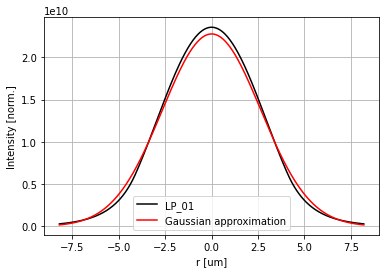

In [8]:
gauss_mode = GaussianMode.from_fiber_parameters(core_radius=smf28_core_diameter / 2,
                                               na=smf28_na,
                                               wl=smf28_wl)
r = np.linspace(-smf28_core_diameter, smf28_core_diameter, 500)
plt.plot(r*1e6, sm_mode.intensity(r=np.abs(r), phi=0), 'k', label='LP_01')
#plt.plot(-r*1000, sm_mode.intensity(r=r, phi=0), 'k')
plt.plot(r*1e6, gauss_mode.intensity(r=np.abs(r), phi=0), 'r', label='Gaussian approximation')
#plt.plot(-r*1000, gauss_mode.intensity(r=r, phi=0), 'r')
plt.xlabel('r [um]')
plt.ylabel('Intensity [norm.]')
plt.legend()
plt.grid(True)

print(f'Core overlap of the LP_01 mode: {sm_mode.core_overlap:.3f}')
print(f'Core overlap of the Gaussian approximation: {gauss_mode.core_overlap:.3f}')

The approximation and the accurate LP mode match each other quite well. The difference in core overlap (which affects gain and absorption) is only ~2 %. 

## 1.6 Fundamental mode at 1.3 um

Let's then look into the fundamental mode at 1310 nm.

LP_0,1 mode of 
fiber with core diameter 8.2 um, NA 0.115 at 1310.00 nm
Effective index: 1.449061
Core overlap: 0.802
Cutoff wavelength: inf nm
Effective area: 66.8 um^2
Effective MFD: 9.22 um


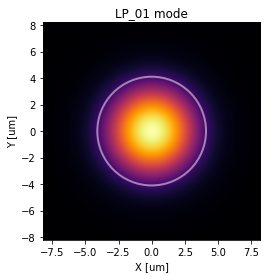

In [9]:
sm_fiber_modes_1310 = mode_solver.find_all_modes(core_radius=smf28_core_diameter / 2,
                                            na=smf28_na,
                                            wl=1310e-9)
assert len(sm_fiber_modes_1310) == 1 # To verify there is only the fundamental mode
sm_mode_1310 = sm_fiber_modes_1310[0]

# Let's first print out the mode's main parameters and plot it
print(sm_mode_1310)
sm_mode_1310.plot_intensity()

The effective MFD appears to be correct (datasheet has 9.2 um), though we are using the same numerical aperture we used at 1550 nm.

## 1.7 Zero-dispersion wavelength
The datasheet specifies zero-dispersion wavelength between 1304 - 1324 nm. Let's compute it at 1 nm accuracy.

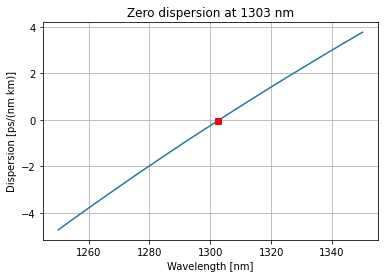

In [10]:
wls_1300 = np.linspace(1250, 1350, 100)*1e-9
dispersion_parameter = np.zeros_like(wls_1300) 
for idx, wl in enumerate(wls_1300):
    mode = mode_solver.find_mode(l=0, m=1,core_radius=smf28_core_diameter/2,
                                 na=smf28_na, wl=wl)
    beta2 = mode.dispersion()[2]
    dispersion_parameter[idx] = beta2_to_d(beta2, wl)

min_dispersion_idx = np.argmin(np.abs(dispersion_parameter))
min_dispersion_wl = wls_1300[min_dispersion_idx]
min_dispersion = dispersion_parameter[min_dispersion_idx]
plt.plot(wls_1300*1e9, dispersion_parameter*1e6)
plt.plot(min_dispersion_wl*1e9, min_dispersion*1e6, 'sr')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Dispersion [ps/(nm km)]')
plt.title(f'Zero dispersion at {min_dispersion_wl*1e9:.0f} nm')
plt.grid(True)
plt.show()

The computed zero-dispersion wavelength is only 1 nm off the specified range, which seems like an acceptable result.

# 2. Few-mode LMA fiber
Next, let's consider a 20/400 fiber geometry typically used in high-power fiber lasers. We start again by solving all modes and plotting/printing the results.

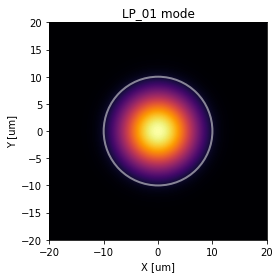

LP_0,1 mode of 
fiber with core diameter 20.0 um, NA 0.065 at 1064.00 nm
Effective index: 1.450735
Core overlap: 0.944
Cutoff wavelength: inf nm
Effective area: 252.9 um^2
Effective MFD: 17.94 um


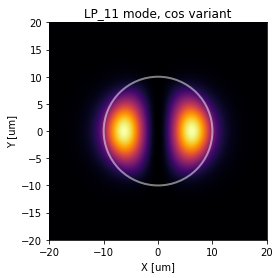

LP_1,1 mode, cos variant of 
fiber with core diameter 20.0 um, NA 0.065 at 1064.00 nm
Effective index: 1.450222
Core overlap: 0.832
Cutoff wavelength: 1698.28 nm
Effective area: 196.5 um^2
Effective MFD: 15.82 um


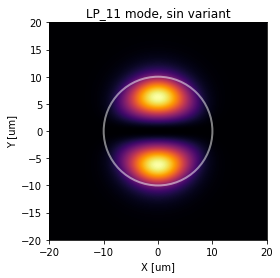

LP_1,1 mode, sin variant of 
fiber with core diameter 20.0 um, NA 0.065 at 1064.00 nm
Effective index: 1.450222
Core overlap: 0.832
Cutoff wavelength: 1698.28 nm
Effective area: 196.5 um^2
Effective MFD: 15.82 um


In [11]:
modes_20_400 = mode_solver.find_all_modes(core_radius=10e-6,
                          na=0.065,
                          wl=1064e-9)

for mode in modes_20_400:
    mode.plot_intensity()
    print(mode)

This fiber supports three transverse modes: the fundamental mode as well as the two rotational variants of the LP_11 mode.

# 3. Multimode fiber
Finally, let's analyze a multimode fiber with 100/125 um geometry and NA of 0.22 at a typical pump wavelength of 976 nm.

In [12]:
modes_mm = mode_solver.find_all_modes(core_radius=50e-6,
                                      na=0.22,
                                      wl=976e-9)

print(f'Total number of modes: {len(modes_mm)}')
for mode in sorted(modes_mm, key=lambda x: -x.cutoff_wl):
    print(f'{mode.name}, \t cutoff={mode.cutoff_wl*1e9:.1f} nm, \t Aeff={mode.effective_area*1e12:.1f} um^2')

Total number of modes: 1263
LP_0,1 mode, 	 cutoff=inf nm, 	 Aeff=3849.4 um^2
LP_1,1 mode, cos variant, 	 cutoff=28740.1 nm, 	 Aeff=2603.0 um^2
LP_1,1 mode, sin variant, 	 cutoff=28740.1 nm, 	 Aeff=2603.0 um^2
LP_0,2 mode, 	 cutoff=18037.7 nm, 	 Aeff=2945.3 um^2
LP_2,1 mode, cos variant, 	 cutoff=18037.7 nm, 	 Aeff=2639.0 um^2
LP_2,1 mode, sin variant, 	 cutoff=18037.7 nm, 	 Aeff=2639.0 um^2
LP_3,1 mode, cos variant, 	 cutoff=13458.0 nm, 	 Aeff=2559.2 um^2
LP_3,1 mode, sin variant, 	 cutoff=13458.0 nm, 	 Aeff=2559.2 um^2
LP_1,2 mode, cos variant, 	 cutoff=12520.7 nm, 	 Aeff=2058.4 um^2
LP_1,2 mode, sin variant, 	 cutoff=12520.7 nm, 	 Aeff=2058.4 um^2
LP_4,1 mode, cos variant, 	 cutoff=10832.8 nm, 	 Aeff=2454.9 um^2
LP_4,1 mode, sin variant, 	 cutoff=10832.8 nm, 	 Aeff=2454.9 um^2
LP_0,3 mode, 	 cutoff=9851.6 nm, 	 Aeff=2618.0 um^2
LP_2,2 mode, cos variant, 	 cutoff=9851.6 nm, 	 Aeff=2225.2 um^2
LP_2,2 mode, sin variant, 	 cutoff=9851.6 nm, 	 Aeff=2225.2 um^2
LP_5,1 mode, cos variant, 	 

LP_3,8 mode, cos variant, 	 cutoff=2520.6 nm, 	 Aeff=1508.6 um^2
LP_3,8 mode, sin variant, 	 cutoff=2520.6 nm, 	 Aeff=1508.6 um^2
LP_1,9 mode, cos variant, 	 cutoff=2513.9 nm, 	 Aeff=1440.7 um^2
LP_1,9 mode, sin variant, 	 cutoff=2513.9 nm, 	 Aeff=1440.7 um^2
LP_23,1 mode, cos variant, 	 cutoff=2507.1 nm, 	 Aeff=1372.6 um^2
LP_23,1 mode, sin variant, 	 cutoff=2507.1 nm, 	 Aeff=1372.6 um^2
LP_10,5 mode, cos variant, 	 cutoff=2505.6 nm, 	 Aeff=1708.0 um^2
LP_10,5 mode, sin variant, 	 cutoff=2505.6 nm, 	 Aeff=1708.0 um^2
LP_19,2 mode, cos variant, 	 cutoff=2495.3 nm, 	 Aeff=1725.6 um^2
LP_19,2 mode, sin variant, 	 cutoff=2495.3 nm, 	 Aeff=1725.6 um^2
LP_13,4 mode, cos variant, 	 cutoff=2466.0 nm, 	 Aeff=2093.7 um^2
LP_13,4 mode, sin variant, 	 cutoff=2466.0 nm, 	 Aeff=2093.7 um^2
LP_16,3 mode, cos variant, 	 cutoff=2459.4 nm, 	 Aeff=1873.6 um^2
LP_16,3 mode, sin variant, 	 cutoff=2459.4 nm, 	 Aeff=1873.6 um^2
LP_8,6 mode, cos variant, 	 cutoff=2451.7 nm, 	 Aeff=1857.4 um^2
LP_8,6 mode, si

LP_22,4 mode, cos variant, 	 cutoff=1773.8 nm, 	 Aeff=2070.4 um^2
LP_22,4 mode, sin variant, 	 cutoff=1773.8 nm, 	 Aeff=2070.4 um^2
LP_19,5 mode, cos variant, 	 cutoff=1773.8 nm, 	 Aeff=2064.6 um^2
LP_19,5 mode, sin variant, 	 cutoff=1773.8 nm, 	 Aeff=2064.6 um^2
LP_9,9 mode, cos variant, 	 cutoff=1761.3 nm, 	 Aeff=1885.1 um^2
LP_9,9 mode, sin variant, 	 cutoff=1761.3 nm, 	 Aeff=1885.1 um^2
LP_34,1 mode, cos variant, 	 cutoff=1759.8 nm, 	 Aeff=1134.8 um^2
LP_34,1 mode, sin variant, 	 cutoff=1759.8 nm, 	 Aeff=1134.8 um^2
LP_14,7 mode, cos variant, 	 cutoff=1751.1 nm, 	 Aeff=2042.6 um^2
LP_14,7 mode, sin variant, 	 cutoff=1751.1 nm, 	 Aeff=2042.6 um^2
LP_7,10 mode, cos variant, 	 cutoff=1745.2 nm, 	 Aeff=1819.8 um^2
LP_7,10 mode, sin variant, 	 cutoff=1745.2 nm, 	 Aeff=1819.8 um^2
LP_26,3 mode, cos variant, 	 cutoff=1738.2 nm, 	 Aeff=1584.9 um^2
LP_26,3 mode, sin variant, 	 cutoff=1738.2 nm, 	 Aeff=1584.9 um^2
LP_5,11 mode, cos variant, 	 cutoff=1734.0 nm, 	 Aeff=1724.5 um^2
LP_5,11 mode

LP_26,5 mode, sin variant, 	 cutoff=1456.8 nm, 	 Aeff=1705.1 um^2
LP_6,13 mode, cos variant, 	 cutoff=1450.5 nm, 	 Aeff=1489.3 um^2
LP_6,13 mode, sin variant, 	 cutoff=1450.5 nm, 	 Aeff=1489.3 um^2
LP_37,2 mode, cos variant, 	 cutoff=1450.0 nm, 	 Aeff=1334.1 um^2
LP_37,2 mode, sin variant, 	 cutoff=1450.0 nm, 	 Aeff=1334.1 um^2
LP_42,1 mode, cos variant, 	 cutoff=1449.0 nm, 	 Aeff=1017.5 um^2
LP_42,1 mode, sin variant, 	 cutoff=1449.0 nm, 	 Aeff=1017.5 um^2
LP_33,3 mode, cos variant, 	 cutoff=1448.6 nm, 	 Aeff=1697.3 um^2
LP_33,3 mode, sin variant, 	 cutoff=1448.6 nm, 	 Aeff=1697.3 um^2
LP_4,14 mode, cos variant, 	 cutoff=1445.4 nm, 	 Aeff=1247.5 um^2
LP_4,14 mode, sin variant, 	 cutoff=1445.4 nm, 	 Aeff=1247.5 um^2
LP_0,16 mode, 	 cutoff=1442.9 nm, 	 Aeff=1975.9 um^2
LP_2,15 mode, cos variant, 	 cutoff=1442.9 nm, 	 Aeff=1257.9 um^2
LP_2,15 mode, sin variant, 	 cutoff=1442.9 nm, 	 Aeff=1257.9 um^2
LP_13,10 mode, cos variant, 	 cutoff=1440.7 nm, 	 Aeff=2678.5 um^2
LP_13,10 mode, sin var

LP_13,12 mode, cos variant, 	 cutoff=1269.6 nm, 	 Aeff=1470.9 um^2
LP_13,12 mode, sin variant, 	 cutoff=1269.6 nm, 	 Aeff=1470.9 um^2
LP_32,5 mode, cos variant, 	 cutoff=1267.0 nm, 	 Aeff=1737.5 um^2
LP_32,5 mode, sin variant, 	 cutoff=1267.0 nm, 	 Aeff=1737.5 um^2
LP_26,7 mode, cos variant, 	 cutoff=1264.6 nm, 	 Aeff=1851.2 um^2
LP_26,7 mode, sin variant, 	 cutoff=1264.6 nm, 	 Aeff=1851.2 um^2
LP_18,10 mode, cos variant, 	 cutoff=1264.2 nm, 	 Aeff=690.7 um^2
LP_18,10 mode, sin variant, 	 cutoff=1264.2 nm, 	 Aeff=690.7 um^2
LP_29,6 mode, cos variant, 	 cutoff=1263.2 nm, 	 Aeff=1514.2 um^2
LP_29,6 mode, sin variant, 	 cutoff=1263.2 nm, 	 Aeff=1514.2 um^2
LP_11,13 mode, cos variant, 	 cutoff=1260.0 nm, 	 Aeff=1132.8 um^2
LP_11,13 mode, sin variant, 	 cutoff=1260.0 nm, 	 Aeff=1132.8 um^2
LP_49,1 mode, cos variant, 	 cutoff=1256.0 nm, 	 Aeff=937.4 um^2
LP_49,1 mode, sin variant, 	 cutoff=1256.0 nm, 	 Aeff=937.4 um^2
LP_9,14 mode, cos variant, 	 cutoff=1252.4 nm, 	 Aeff=1839.1 um^2
LP_9,14 

LP_20,11 mode, sin variant, 	 cutoff=1140.2 nm, 	 Aeff=1854.8 um^2
LP_28,8 mode, cos variant, 	 cutoff=1139.6 nm, 	 Aeff=991.1 um^2
LP_28,8 mode, sin variant, 	 cutoff=1139.6 nm, 	 Aeff=991.1 um^2
LP_49,2 mode, cos variant, 	 cutoff=1139.4 nm, 	 Aeff=1204.9 um^2
LP_49,2 mode, sin variant, 	 cutoff=1139.4 nm, 	 Aeff=1204.9 um^2
LP_34,6 mode, cos variant, 	 cutoff=1138.8 nm, 	 Aeff=1973.9 um^2
LP_34,6 mode, sin variant, 	 cutoff=1138.8 nm, 	 Aeff=1973.9 um^2
LP_31,7 mode, cos variant, 	 cutoff=1137.4 nm, 	 Aeff=2073.5 um^2
LP_31,7 mode, sin variant, 	 cutoff=1137.4 nm, 	 Aeff=2073.5 um^2
LP_13,14 mode, cos variant, 	 cutoff=1135.6 nm, 	 Aeff=2334.0 um^2
LP_13,14 mode, sin variant, 	 cutoff=1135.6 nm, 	 Aeff=2334.0 um^2
LP_41,4 mode, cos variant, 	 cutoff=1134.1 nm, 	 Aeff=1348.3 um^2
LP_41,4 mode, sin variant, 	 cutoff=1134.1 nm, 	 Aeff=1348.3 um^2
LP_45,3 mode, cos variant, 	 cutoff=1131.4 nm, 	 Aeff=1195.1 um^2
LP_45,3 mode, sin variant, 	 cutoff=1131.4 nm, 	 Aeff=1195.1 um^2
LP_23,10 

LP_17,14 mode, cos variant, 	 cutoff=1041.0 nm, 	 Aeff=1730.0 um^2
LP_17,14 mode, sin variant, 	 cutoff=1041.0 nm, 	 Aeff=1730.0 um^2
LP_60,1 mode, cos variant, 	 cutoff=1039.5 nm, 	 Aeff=839.6 um^2
LP_60,1 mode, sin variant, 	 cutoff=1039.5 nm, 	 Aeff=839.6 um^2
LP_22,12 mode, cos variant, 	 cutoff=1038.4 nm, 	 Aeff=1991.6 um^2
LP_22,12 mode, sin variant, 	 cutoff=1038.4 nm, 	 Aeff=1991.6 um^2
LP_6,19 mode, cos variant, 	 cutoff=1038.2 nm, 	 Aeff=1246.1 um^2
LP_6,19 mode, sin variant, 	 cutoff=1038.2 nm, 	 Aeff=1246.1 um^2
LP_46,4 mode, cos variant, 	 cutoff=1038.0 nm, 	 Aeff=1432.1 um^2
LP_46,4 mode, sin variant, 	 cutoff=1038.0 nm, 	 Aeff=1432.1 um^2
LP_39,6 mode, cos variant, 	 cutoff=1038.0 nm, 	 Aeff=1783.8 um^2
LP_39,6 mode, sin variant, 	 cutoff=1038.0 nm, 	 Aeff=1783.8 um^2
LP_50,3 mode, cos variant, 	 cutoff=1037.8 nm, 	 Aeff=1308.2 um^2
LP_50,3 mode, sin variant, 	 cutoff=1037.8 nm, 	 Aeff=1308.2 um^2
LP_30,9 mode, cos variant, 	 cutoff=1037.3 nm, 	 Aeff=2369.3 um^2
LP_30,9 

Plotting all the modes would be unfeasible but we can plot a few at random.

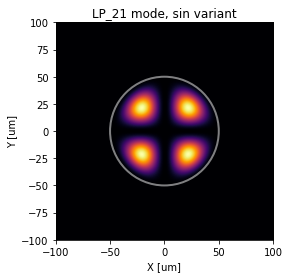

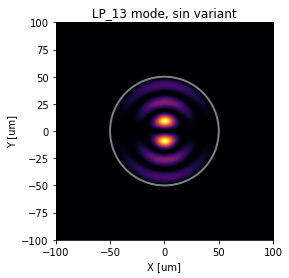

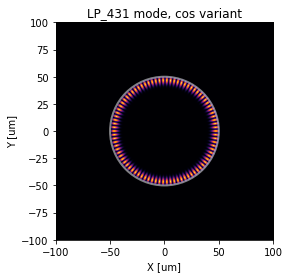

In [13]:
modes_mm[5].plot_intensity()
modes_mm[20].plot_intensity()
modes_mm[600].plot_intensity()

This concludes our brief tour of the LP mode solver in pyfiberamp.

If you want to ask a question or send feedback about this example, please open a new issue on GitHub or contact me at <pyfiberamp@gmail.com>.